# STANDALONE STUDY
## **SPATIAL FOURBAR**
-----------------

## Environment Setup
--------------------

### Colab Session
*Run if in a Colab Session Only!*

#### Setting-up Colab Virtual Machine
This will clone the package repository and install the needed modules into the Virtual Machine dedicated for the running notebook session.

In [ ]:
!git clone https://github.com/khaledghobashy/smbd.git
!cd smbd/smbd/numenv/python/numerics/core/math_funcs/_cython_definitions && python setup.py build_ext -if
!pip install sympy==1.4

Adding package path to the python system path and creating a new folder, **smbd_project**, where we can store the model files and results.

In [ ]:
import os
import sys

pkg_path = '/content/smbd'
sys.path.append(pkg_path)

os.mkdir('smbd_project')
os.chdir('smbd_project')

#### Rendering SymPy in Colab
Rendering SymPy equations in Colab requires the MathJax javascript library to be available within each cell output. The following defines an execution hook that loads it automatically each time you execute a cell.

In [ ]:
from IPython.display import Math, HTML

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

---------------------------------------------------------------

### Local Session
*Run if on your Local Machine!*</br>

The ```pkg_path``` variable is where you have the repository on your machine and should be changed to where you cloned the repository.</br>
*Uncomment the code below and change the ```pkg_path``` variable!*

In [1]:
#import sys
#pkg_path = '/path/to/smbd'
#sys.path.append(pkg_path)

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM DESCRIPTION**
-------------------------

### **Important Note**
The tool uses [euler-parameters](https://en.wikibooks.org/wiki/Multibody_Mechanics/Euler_Parameters) -which is a 4D unit quaternion- to represents bodies orientation in space. This makes the generalized coordinates used to fully define a body in space to be **7,** instead of **6**, it also adds an algebraic equation to the constraints that ensures the unity/normalization of the body quaternion. This is an important remark as the calculations of the degrees-of-freedom depends on it.

### **Summary**
A four-bar linkage is the simplest movable closed chain linkage. It consists of four bodies, called bars or links, connected in a loop by four joints that gives the mechanism only 1 degree-of-freedom. More general information can be found on [wikipedia](https://en.wikipedia.org/wiki/Four-bar_linkage).

### **Topology Layout**
The mechanism consists of 3 Bodies + 1 Ground. Therefore, total system coordinates -including the ground- is $$n=n_b\times7 = 4\times7 = 28$$ 
where $n_b$ is the total number of bodies. The list of bodies is given below:
- Crank $l_1$.
- Connecting-Rod $l_2$.
- Rocker $l_3$.

The system connectivity is as follows:
- Crank $l_1$ is connected to the ground by a revolute joint, resulting in constraint equations $n_{c,rev} = 5$
- Connecting-Rod $l_2$ is connected to the Crank $l_1$ by a spherical joint, resulting in constraint equations $n_{c,sph} = 3$
- Rocker $l_3$ is connected to Connecting-Rod $l_2$ by a universal joint, resulting in constraint equations $n_{c,uni} = 4$
- Rocker $l_3$ is connected to the ground by a revolute joint, resulting in constraint equations $n_{c,tri} = 5$
- Total free DOF is $$n-( n_{c,rev}+n_{c,sph}+n_{c,uni}+n_{c,P}+n_{c,g}) = 28-(10+3+4+(3\times1)+7) = 28-27 = 1$$, where the $n_{c,P}$ and $n_{c,g}$ represents the constraints due to euler-parameters normalization equations and the ground-constraints respectively.
- The Crank revolute joint is actuated by a rotational actuator, resulting in constraint equations $n_{c,act} = 1$

| Joint Name  | Body i         | Body j         | Joint Type | $n_c$ |
|:-----------:|:-------------- |:-------------- | ---------- | ----- |
| a           | Ground         | Crank          | Revolute   | 5     |
| b           | Crank          | Connecting-Rod | Spherical  | 3     |
| c           | Connecting-Rod | Rocker         | Universal  | 4     |
| d           | Rocker         | Ground         | Revolute   | 5     |

---------------------------------------------------------------
---------------------------------------------------------------

## **CODE GENERATION**
----------------------

This step aims to create a valid code that can be used for numerical simulation. We will use both the ***python code generator*** and the **C++ code generator** to create a valid numerical simulation environment in python and C++.</br>

Theoretically, the symbolic environment is uncoupled from the simulation environment, which opens the door to create various simulation environments that can be in any language.

### Generating Python Numerical Environment

In [1]:
from uraeus.nmbd.python import numenv as py_numenv

Failed importing compiled Cython matrices!
Falling back to numba mode.


In [2]:
# Creating the needed directories structure for the source code.
py_project = py_numenv.standalone_project(stpl_file='model_data\spatial_fourbar.stpl', parent_dir='')
py_project.create_dirs()

# Generating the source code.
py_project.write_topology_code()

File full path : numenv\python\src\spatial_fourbar.py


---------------------------------------------------------------
---------------------------------------------------------------

## **PYTHON NUMERICAL SIMULATION**
---------------------------

The **numerical simulation** step is also a straight forward one. We start by importing helper libraries like **numpy** and **pandas**, then we import the ```multibody_system``` class and the ```simulation``` class that will be used to create a numerical system and a simulation instance respectively. And finally we import the generated code files from the previous step.

The steps then can be summarized as follows:
1. Create a numerical model instance by passing the generated topology code to the ```multibody_system``` class.
2. Make the configuration of that instance refers to the generated configuration code.
3. Setting the numerical data of the configuration.
4. Setting the **user-defined functions** that will be used for the actuators/forces.
5. Creating a **simulation instance**, set the desired time-sampling and run the simulation.
6. Plotting the results.

###  Imports

In [3]:
import numpy as np
from uraeus.nmbd.python import multibody_system, simulation, configuration

In [4]:
# Importing the generated modules/souce-code of the model.
from numenv.python.src import spatial_fourbar

### Creating Numerical Model

In [5]:
num_model  = multibody_system(spatial_fourbar)

num_config = configuration('base')
num_config.construct_from_json('model_data\spatial_fourbar_cfg.json')

num_model.topology.config = num_config

### Setting Configuration Numerical Data

In [6]:
# Specifying the Numerical Configuration of the System.
# ====================================================

num_config.hps_a.flat[:] = 0, 0, 0
num_config.hps_b.flat[:] = 0, 0, 200
num_config.hps_c.flat[:] = -750, -850, 650
num_config.hps_d.flat[:] = -400, -850, 0

num_config.vcs_x.flat[:] = 1, 0, 0
num_config.vcs_y.flat[:] = 0, 1, 0
num_config.vcs_z.flat[:] = 0, 0, 1

num_config.s_links_ro = 20

In [7]:
num_config.assemble()

### Setting User Functions.

#### Actuators

Here we set the actuation functions of the system actuators.

In [8]:
num_config.UF_mcs_act = lambda t : -np.deg2rad(360)*t

### Creating Simulation Instance

A simulation instance takes in three arguments, the simulation ```name```, the numerical ```model``` and the simulation ```typ```. The simulation ```typ``` argument should be either *kds* for kinematically driven systems or *dds* for dynamically driven systems. For our case, the system is fully defined kinematically, and therefore we will set the ```typ``` as *kds*.

In [9]:
sim = simulation('sim', num_model, 'kds')
sim.set_time_array(5, 2e-2)
sim.solve()


Running System Kinematic Analysis:
[=========================] 100%, (249/249) steps. ET = 1.040 (s)



In [11]:
sim.save_results('results', 'kinSim')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\khaledghobashy\\github\\uraeus_smbd\\examples\\standalone_models\\notebooks\\spatial_fourbar\\results\\kinSim.csv'

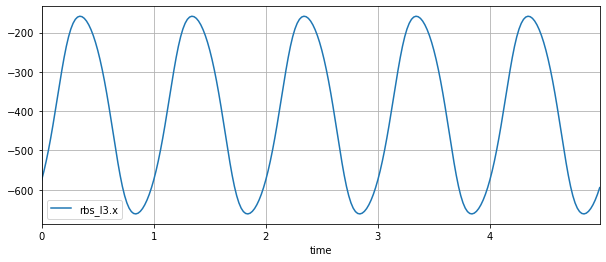

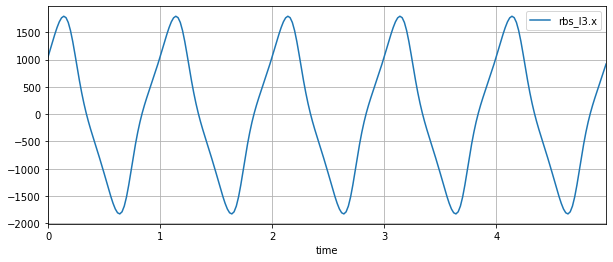

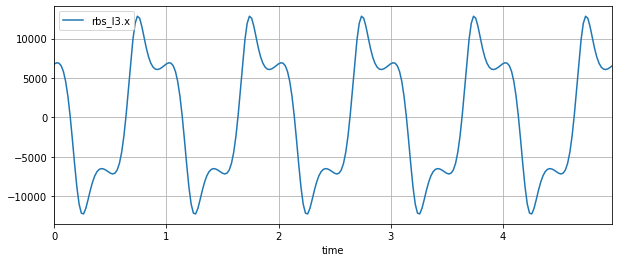

In [10]:
sim.soln.pos_dataframe.plot(x='time', y='rbs_l3.x', grid=True, figsize=(10,4))
sim.soln.vel_dataframe.plot(x='time', y='rbs_l3.x', grid=True, figsize=(10,4))
sim.soln.acc_dataframe.plot(x='time', y='rbs_l3.x', grid=True, figsize=(10,4))


### Evaluating System Reactions

Here we take the simulation a step further by making it an inverse dynamics problem and evaluating the reactions resulted due the imposed constraints, either by joints or actuators. This step is only valid if you have defined the numerical values of the inertia properties of the system.

In [12]:
sim.eval_reactions()


Evaluating System Constraints' Forces.
[=========================] 100%, (250/250) steps. ET = 0.402 (s)

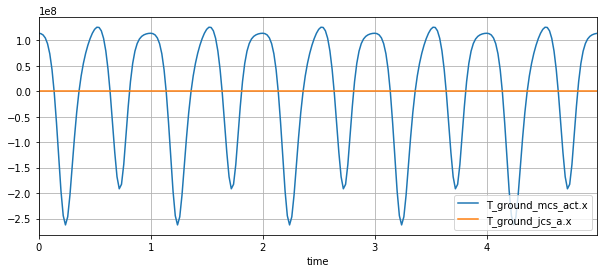

In [13]:
sim.soln.reactions_dataframe.plot(x='time', y=['T_ground_mcs_act.x', 'T_ground_jcs_a.x'],
                                   grid=True, figsize=(10,4))

---------------------------------------------------------------
---------------------------------------------------------------